### LoRA Fine-Tuning with MLX LM

In this notebook, we'll walk through how to [LoRA fine-tune](https://arxiv.org/abs/2106.09685) an LLM with MLX LM. We'll use the [HellaSwag](https://rowanzellers.com/hellaswag/) dataset for common sense reasoning as an example. An outline:

1. Download the dataset and prepare it in the right format for MLX LM.
2. Setup and run LoRA training. We'll show how to capture the training logs and plot some statistics to visualize the performance.
3. Evaluate on the test set. We'll compute the final question-answer accuracy of the fine-tuned model.
4. Fuse the resulting adapters into the base model and upload to Hugging Face.
5. Discuss tips for debugging accuracy and efficiency.

### Install dependencies

Run:

```bash
CONDA_SUBDIR=osx-arm64 conda create -n fine-tune-llm python=3.11
conda activate fine-tune-llm
conda config --env --set subdir osx-arm64
````

Then:

```bash
pip install -r requirements.txt
````

In [23]:
import matplotlib.pyplot as plt
import mlx.core as mx
import mlx.optimizers as optim
import mlx.core as mx
import mlx.optimizers as optim
from mlx.utils import tree_flatten
from mlx_lm import load, generate
from mlx_lm.tuner import train, evaluate, TrainingArgs
from mlx_lm.tuner import linear_to_lora_layers
import tqdm
import json
import random
from pathlib import Path
from datasets import load_dataset
import os
from dotenv import load_dotenv

load_dotenv()

True

### Pull dataset from Hugging Face

In [3]:
# Load the dataset from Hugging Face
dataset = load_dataset("didierlopes/my-blog-qa-dataset")

# Print some information about the dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['title', 'conversation', 'context', 'url', 'date'],
        num_rows: 91
    })
})

### Ensure that the dataset is split into train, validation and test

Since this dataset only has train examples, we need to separate some of these blog posts for testing so we can assess whether fine-tuning accuracy is improving.

Put the data splits in the MLX LM training format.

The format simply expects the data to be in a container which supports random access to the individual examples (e.g. a Python `list`):
```
["An example for the model.", "Another example for the model.", ...]
```

For more details, see the [documentation on supported formats](https://github.com/ml-explore/mlx-examples/blob/main/llms/mlx_lm/LORA.md#Data).

In [4]:
# Get the train dataset
all_data = dataset['train']

# Convert to list of dictionaries
data_list = all_data.to_list()

# Define test_size and val_size
test_size = 0.1  # 10% of conversation size
val_size = 0.2   # 20% of conversation size

# Initialize train, validation and test sets
train_set = []
val_set = []
test_set = []

for sample in data_list:
    conversation = sample["conversation"]
    conversation_samples = []

    for i in range(0, len(conversation), 2):
        user_message = conversation[i]
        assistant_message = conversation[i+1] if i+1 < len(conversation) else None
        
        if assistant_message:
            # Remove newlines from the messages so they don't interfere with the format
            question = user_message["content"].replace("\n", " ")
            answer = assistant_message["content"].replace("\n", " ")
            
            formatted_sample = f"{question}\n{answer}"
            conversation_samples.append(formatted_sample)

    # Shuffle the conversation samples randomly
    random.shuffle(conversation_samples)

    # Calculate split indices for this conversation
    total_size = len(conversation_samples)
    test_idx = int(total_size * (1 - test_size))
    val_idx = int(test_idx * (1 - val_size))

    # Split the shuffled conversation samples
    train_set.extend(conversation_samples[:val_idx])
    val_set.extend(conversation_samples[val_idx:test_idx])
    test_set.extend(conversation_samples[test_idx:])

print(f"Train set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")

Train set size: 1466
Validation set size: 408
Test set size: 255


### Fine tune

For fine-tuning, we'll use Microsoft's [Phi-3 mini](https://huggingface.co/microsoft/Phi-3-mini-4k-instruct).

At 3.8 billion parameters, Phi-3 mini is a high-quality model that is also fast to fine-tune on most Apple silicon machines.

Setup the LoRA parameters and make the training arguments.

See the [training argument class](https://github.com/ml-explore/mlx-examples/blob/81318ad4a8b2ca5fd1431a42db2b0244d16be851/llms/mlx_lm/tuner/trainer.py#L31-L63) for a more detailed list of training parameters. 

Recall the LoRA update is $W^\top \mathbf{x} + c \cdot \mathbf{a} \mathbf{b}^\top \mathbf{x}$ where $\mathbf{a}$ has shape `(D, rank)`.

With that in mind, the LoRA parameters to attend to are:
- `lora_layers`: The number of Transformer blocks from the top of the model to adapt.
- `rank`: The rank of the low-rank adapters. A larger rank implies more adapter parameters per linear layer.
- `scale`: This is the constant $c$ that scales the low-rank update.

In [5]:
# Make a directory to save the adapter config and weights
adapter_path = Path("adapters")
adapter_path.mkdir(parents=True, exist_ok=True)

lora_config = {
    "num_layers": 32,
    "lora_layers": 8,  # Reduced from 16 to prevent overfitting
    "lora_parameters": {
        "rank": 8,     # Reduced from 16 to stabilize training
        "scale": 5.0,  # Further reduced to improve stability
        "dropout": 0.2 # Increased dropout to reduce overfitting
    }
}

# Save the LoRA config to the adapter path
with open(adapter_path / "adapter_config.json", "w") as fid:
    json.dump(lora_config, fid, indent=4)    

training_args = TrainingArgs(
    adapter_file=adapter_path / "adapters.safetensors",
    iters=500,
    steps_per_eval=100,
    batch_size=16,
)

Next, load the Phi-3 mini model. Note this may take a few minutes to download from HuggingFace if you haven't downloaded it before.

In [6]:
model_path = "microsoft/Phi-3-mini-4k-instruct"
model, tokenizer = load(model_path)

Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 202698.71it/s]


After loading the model, freeze it's parameters so we don't train them.

In [7]:
model.freeze()

Model(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072)
    (layers.0): TransformerBlock(
      (self_attn): Attention(
        (qkv_proj): Linear(input_dims=3072, output_dims=9216, bias=False)
        (o_proj): Linear(input_dims=3072, output_dims=3072, bias=False)
        (rope): RoPE(96, traditional=False)
      )
      (mlp): MLP(
        (gate_up_proj): Linear(input_dims=3072, output_dims=16384, bias=False)
        (down_proj): Linear(input_dims=8192, output_dims=3072, bias=False)
      )
      (input_layernorm): RMSNorm(3072, eps=1e-05)
      (post_attention_layernorm): RMSNorm(3072, eps=1e-05)
    )
    (layers.1): TransformerBlock(
      (self_attn): Attention(
        (qkv_proj): Linear(input_dims=3072, output_dims=9216, bias=False)
        (o_proj): Linear(input_dims=3072, output_dims=3072, bias=False)
        (rope): RoPE(96, traditional=False)
      )
      (mlp): MLP(
        (gate_up_proj): Linear(input_dims=3072, output_dims=16384, bias=False)
        (dow

Then convert linear layers to LoRA layers using the MLX LM utility `linear_to_lora_layers`.
 
The adapters in the `LoRA` layers are not frozen, so they will be included in the model's `trainable_parameters`.
 
Check-out the [LoRA layer implementation](https://github.com/ml-explore/mlx-examples/blob/81318ad4a8b2ca5fd1431a42db2b0244d16be851/llms/mlx_lm/tuner/lora.py#L72-L104) to see how it all works.

By default, MLX LM only adapts the query, key, and value projection matrices for Phi-3.

You can specify the layers to adapt by setting `lora_parameters["keys"]` to a list of layer names. In this case it defaults to `["attn.qkv_proj"]`. 

In [8]:
linear_to_lora_layers(model, lora_config["lora_layers"], lora_config["lora_parameters"])

num_train_params = (
    sum(v.size for _, v in tree_flatten(model.trainable_parameters()))
)
print(f"Number of trainable parameters: {num_train_params}")

Number of trainable parameters: 3145728


Let's put the model in training mode, which enables specific behaviors needed during training like dropout (randomly deactivating neurons to prevent overfitting) and batch normalization (computing statistics from the current batch).

This differs from evaluation mode (`model.eval()`), where these features behave differently to ensure consistent inference results.

In [9]:
model.train()

Model(
  (model): Phi3Model(
    (embed_tokens): Embedding(32064, 3072)
    (layers.0): TransformerBlock(
      (self_attn): Attention(
        (qkv_proj): LoRALinear(
          (linear): Linear(input_dims=3072, output_dims=9216, bias=False)
          (dropout): Dropout(p=0.19999999999999996)
        )
        (o_proj): Linear(input_dims=3072, output_dims=3072, bias=False)
        (rope): RoPE(96, traditional=False)
      )
      (mlp): MLP(
        (gate_up_proj): Linear(input_dims=3072, output_dims=16384, bias=False)
        (down_proj): Linear(input_dims=8192, output_dims=3072, bias=False)
      )
      (input_layernorm): RMSNorm(3072, eps=1e-05)
      (post_attention_layernorm): RMSNorm(3072, eps=1e-05)
    )
    (layers.1): TransformerBlock(
      (self_attn): Attention(
        (qkv_proj): LoRALinear(
          (linear): Linear(input_dims=3072, output_dims=9216, bias=False)
          (dropout): Dropout(p=0.19999999999999996)
        )
        (o_proj): Linear(input_dims=3072, out

Let's use `Adam` for the optimizer, but you can specify any [optimizer](https://ml-explore.github.io/mlx/build/html/python/optimizers/common_optimizers.html) with any [scheduler](https://ml-explore.github.io/mlx/build/html/python/optimizers/schedulers.html).


In [10]:
opt = optim.Adam(learning_rate=5e-6)

Custom class to capture the training and validation loss to plot it later.

In [11]:
class Metrics:
    train_losses = []
    val_losses = []
    def on_train_loss_report(self, info):
        self.train_losses.append((info["iteration"], info["train_loss"]))
    def on_val_loss_report(self, info):
        self.val_losses.append((info["iteration"], info["val_loss"]))

metrics = Metrics()

Now we're ready to actually train the model.

In [12]:
train(
    model=model,
    tokenizer=tokenizer,
    args=training_args,
    optimizer=opt,
    train_dataset=train_set,
    val_dataset=val_set,
    training_callback=metrics,
)

Starting training..., iters: 500
Iter 1: Val loss 2.248, Val took 34.128s
Iter 10: Train loss 2.251, Learning Rate 5.000e-06, It/sec 0.329, Tokens/sec 571.360, Trained Tokens 17372, Peak mem 20.767 GB
Iter 20: Train loss 2.231, Learning Rate 5.000e-06, It/sec 0.364, Tokens/sec 584.958, Trained Tokens 33434, Peak mem 20.767 GB
Iter 30: Train loss 2.148, Learning Rate 5.000e-06, It/sec 0.363, Tokens/sec 601.403, Trained Tokens 49999, Peak mem 21.507 GB
Iter 40: Train loss 1.949, Learning Rate 5.000e-06, It/sec 0.306, Tokens/sec 567.238, Trained Tokens 68543, Peak mem 26.862 GB
Iter 50: Train loss 2.012, Learning Rate 5.000e-06, It/sec 0.317, Tokens/sec 568.714, Trained Tokens 86465, Peak mem 26.862 GB
Iter 60: Train loss 1.883, Learning Rate 5.000e-06, It/sec 0.345, Tokens/sec 581.498, Trained Tokens 103325, Peak mem 26.862 GB
Iter 70: Train loss 1.906, Learning Rate 5.000e-06, It/sec 0.310, Tokens/sec 537.536, Trained Tokens 120653, Peak mem 26.862 GB
Iter 80: Train loss 1.893, Learning

The adapters are saved every 100 iterations along with the final adapters in `adapters.safetensors`.

In [13]:
!ls adapters/

0000100_adapters.safetensors 0000500_adapters.safetensors
0000200_adapters.safetensors adapter_config.json
0000300_adapters.safetensors adapters.safetensors
0000400_adapters.safetensors


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Next, let's plot the training and validation losses to see how well the adapters fit the data.

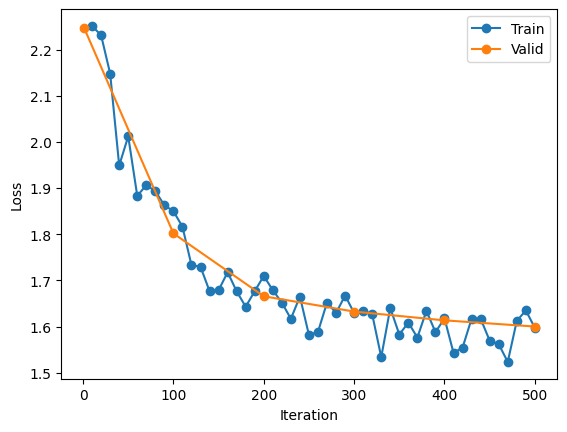

In [14]:
train_its, train_losses = zip(*metrics.train_losses)
val_its, val_losses = zip(*metrics.val_losses)
plt.plot(train_its, train_losses, '-o')
plt.plot(val_its, val_losses, '-o')
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend(['Train', "Valid"]);

### Evaluate

The training and validation loss are only part of the story.

Let's see how good is the model trying to produce answers the same way Didier would.

In [15]:
test_set_questions, test_set_answers = zip(*[pair.split("\n") for pair in test_set])

### Use Llama 3.2 through Ollama for evaluation purposes

In [16]:
import requests
import json
from tqdm import tqdm
import numpy as np
from time import sleep

def get_llama_response(prompt, model="llama3.2:latest"):
    """Send request to local Ollama instance"""
    try:
        response = requests.post('http://localhost:11434/api/generate',
                               json={
                                   "model": model,
                                   "prompt": prompt,
                                   "stream": False
                               })
        return response.json()['response'].strip()
    except Exception as e:
        print(f"Error calling Ollama: {e}")
        return None

def evaluate_with_llama(test_set_questions, test_set_answers, model, tokenizer):
    scores = []
    evaluation_prompt = """You are an expert at evaluating text similarity.
    Rate the semantic similarity between two texts on a scale of 0-1,
    where 1 means identical meaning and 0 means completely different.
    Respond with only the numerical score, nothing else.
    
    Text 1: {ground_truth}
    Text 2: {response}
    
    Similarity score (0-1):"""
    
    for prompt, ground_truth in tqdm(zip(test_set_questions, test_set_answers)):
        # Generate response from your fine-tuned model
        response = generate(model, tokenizer, prompt, max_tokens=200)
        
        try:
            # Get similarity score from Llama
            llama_prompt = evaluation_prompt.format(
                ground_truth=ground_truth,
                response=response
            )
            
            score_text = get_llama_response(llama_prompt, model="llama3.2:latest")
            
            # Extract numerical score (handling potential formatting issues)
            try:
                score = float(score_text.strip())
                # Ensure score is in valid range
                score = max(0, min(1, score))
                scores.append(score)
            except ValueError:
                print(f"Could not parse score from Llama response: {score_text}")
                continue
            
            # Small delay to prevent overwhelming Ollama
            sleep(0.1)
            
        except Exception as e:
            print(f"Error during evaluation: {e}")
            continue
    
    return scores


# If we are running a new Python session, we don't need to train the model again
# but can load the base model with the adapter safetensors directly
# model_lora, _ = load(model_path, adapter_path="adapters")

# Run evaluation
scores = evaluate_with_llama(test_set_questions, test_set_answers, model, tokenizer)
scores[:5]

255it [09:48,  2.31s/it]


[0.66, 0.32, 0.33, 0.55, 0.4]


Detailed Statistics:
----------------------------------------
Mean: 0.440
Median: 0.450
Std Dev: 0.208
Min: 0.000
Max: 0.900
Scores ≥ 0.7: 11.4%
Scores ≤ 0.3: 24.7%


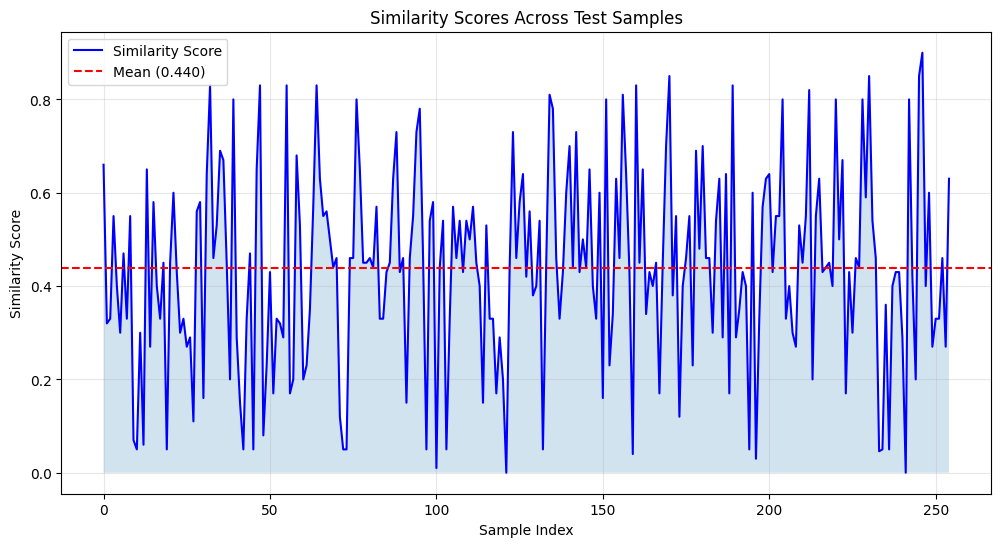

In [17]:
def plot_and_analyze_scores(scores):
    # Create figure and axis
    plt.figure(figsize=(12, 6))
    
    # Plot scores
    plt.plot(range(len(scores)), scores, 'b-', label='Similarity Score')
    plt.fill_between(range(len(scores)), scores, alpha=0.2)
    
    # Add mean line
    mean_score = np.mean(scores)
    plt.axhline(y=mean_score, color='r', linestyle='--', label=f'Mean ({mean_score:.3f})')
    
    # Customize plot
    plt.xlabel('Sample Index')
    plt.ylabel('Similarity Score')
    plt.title('Similarity Scores Across Test Samples')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Calculate statistics
    stats = {
        'Mean': np.mean(scores),
        'Median': np.median(scores),
        'Std Dev': np.std(scores),
        'Min': np.min(scores),
        'Max': np.max(scores),
        'Scores ≥ 0.7': np.mean(np.array(scores) >= 0.7),  # Proportion of good matches
        'Scores ≤ 0.3': np.mean(np.array(scores) <= 0.3)   # Proportion of poor matches
    }
    
    # Print statistics
    print("\nDetailed Statistics:")
    print("-" * 40)
    for metric, value in stats.items():
        if metric in ['Scores ≥ 0.7', 'Scores ≤ 0.3']:
            print(f"{metric}: {value:.1%}")
        else:
            print(f"{metric}: {value:.3f}")
    
    plt.show()
    return stats

# Use the function
stats = plot_and_analyze_scores(scores)

### Compare against benchmark model

Fetching 13 files: 100%|██████████| 13/13 [00:00<00:00, 96165.70it/s]
255it [19:53,  4.68s/it]


Detailed Statistics:
----------------------------------------
Mean: 0.444
Median: 0.460
Std Dev: 0.223
Min: 0.000
Max: 0.900
Scores ≥ 0.7: 12.5%
Scores ≤ 0.3: 21.2%


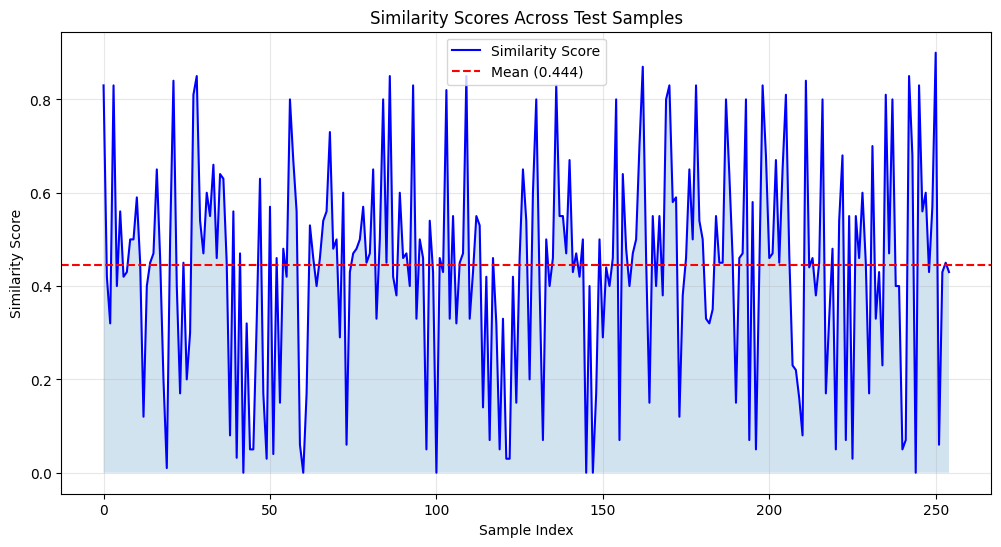

{'Mean': np.float64(0.44447843137254894),
 'Median': np.float64(0.46),
 'Std Dev': np.float64(0.22266874747800094),
 'Min': np.float64(0.0),
 'Max': np.float64(0.9),
 'Scores ≥ 0.7': np.float64(0.12549019607843137),
 'Scores ≤ 0.3': np.float64(0.21176470588235294)}

In [18]:
model_path = "microsoft/Phi-3-mini-4k-instruct"
base_model, base_tokenizer = load(model_path)

scores = evaluate_with_llama(test_set_questions, test_set_answers, base_model, base_tokenizer)

stats = plot_and_analyze_scores(scores)

### Fuse Adapters

Sometimes its convenient to fuse the adapters into the base model to create a single adapted model.

MLX LM has a fuse script just for that.

The adapted weights are: $\tilde{W} = W + c \cdot \mathbf{b}^\top \mathbf{a}$. Note, this process can be destructive if the inputs are in low precision and they have very different magnitudes. Tuning the `scale` parameter, $c$, prior to fine-tuning can improve the model performance after fusion.

To see more options for fusing the model, including how to upload to HuggingFace [check the documentation](https://github.com/ml-explore/mlx-examples/blob/main/llms/mlx_lm/LORA.md#fuse).

In [19]:
import os
# Disable parallelism to prevent issues with the tokenizer
os.environ["TOKENIZERS_PARALLELISM"] = "false"

!mlx_lm.fuse --model {model_path} --adapter-path adapters --save-path lora_fused_model

Loading pretrained model
Fetching 13 files: 100%|████████████████████| 13/13 [00:00<00:00, 156683.77it/s]


Once the adapters are fused, we can rerun the evaluation using the fused model to make sure it worked.

255it [09:12,  2.16s/it]


Detailed Statistics:
----------------------------------------
Mean: 0.458
Median: 0.450
Std Dev: 0.203
Min: 0.000
Max: 0.850
Scores ≥ 0.7: 14.1%
Scores ≤ 0.3: 20.4%


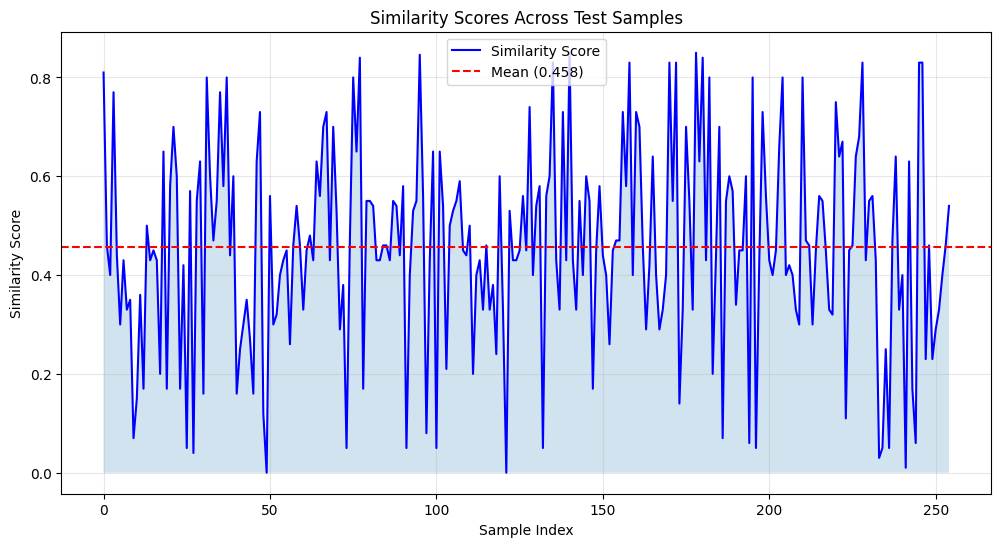

In [21]:
fused_model, fused_tokenizer = load("lora_fused_model")
scores = evaluate_with_llama(test_set_questions, test_set_answers, fused_model, fused_tokenizer)

stats = plot_and_analyze_scores(scores)


Detailed Statistics:
----------------------------------------
Mean: 0.534
Median: 0.550
Std Dev: 0.213
Min: 0.000
Max: 0.850
Scores ≥ 0.7: 26.5%
Scores ≤ 0.3: 10.8%


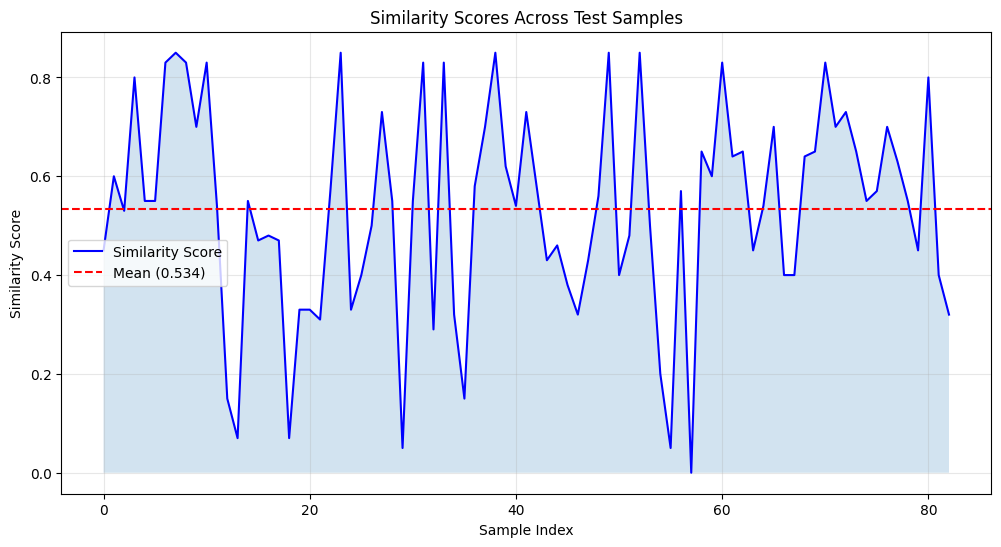

In [121]:
def plot_and_analyze_scores(scores):
    # Create figure and axis
    plt.figure(figsize=(12, 6))
    
    # Plot scores
    plt.plot(range(len(scores)), scores, 'b-', label='Similarity Score')
    plt.fill_between(range(len(scores)), scores, alpha=0.2)
    
    # Add mean line
    mean_score = np.mean(scores)
    plt.axhline(y=mean_score, color='r', linestyle='--', label=f'Mean ({mean_score:.3f})')
    
    # Customize plot
    plt.xlabel('Sample Index')
    plt.ylabel('Similarity Score')
    plt.title('Similarity Scores Across Test Samples')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # Calculate statistics
    stats = {
        'Mean': np.mean(scores),
        'Median': np.median(scores),
        'Std Dev': np.std(scores),
        'Min': np.min(scores),
        'Max': np.max(scores),
        'Scores ≥ 0.7': np.mean(np.array(scores) >= 0.7),  # Proportion of good matches
        'Scores ≤ 0.3': np.mean(np.array(scores) <= 0.3)   # Proportion of poor matches
    }
    
    # Print statistics
    print("\nDetailed Statistics:")
    print("-" * 40)
    for metric, value in stats.items():
        if metric in ['Scores ≥ 0.7', 'Scores ≤ 0.3']:
            print(f"{metric}: {value:.1%}")
        else:
            print(f"{metric}: {value:.3f}")
    
    plt.show()
    return stats

# Use the function
stats = plot_and_analyze_scores(scores)

### Push model to hugging face

In [25]:
# Define the model and dataset repository names
model_repo = "didierlopes/phi-3-mini-4k-instruct-ft-on-didier-blog"

from huggingface_hub import HfApi
import shutil
import os

# First save the model locally with all necessary files
save_directory = "lora_fused_model"

# Ensure the model files are properly saved in the directory
# The files should already be there from the previous fuse step

# Initialize the Hugging Face API
api = HfApi()

# Create the model repository
api.create_repo(
    repo_id=model_repo,
    private=False,
    exist_ok=True,
    token=os.getenv('HF_TOKEN')
)

# Upload the entire directory
api.upload_folder(
    folder_path=save_directory,
    repo_id=model_repo,
    token=os.getenv('HF_TOKEN')
)

print(f"Model pushed to: https://huggingface.co/{model_repo}")




Upload 3 LFS files:   0%|          | 0/3 [00:00<?, ?it/s]







tokenizer.model: 100%|██████████| 500k/500k [00:00<00:00, 1.08MB/s]


































































































































































































































































































































































































































































































































































































































































































































































































































































































Model pushed to: https://huggingface.co/didierlopes/phi-3-mini-4k-instruct-ft-on-didier-blog


### Troubleshooting

#### Results

To figure out why your LoRA adapters are not working well it's critical to plot both the trianing loss and validation loss over the duration of fine-tuning. There are really only two cases to consider: underfitting or overfitting. And you can figure out which regime you are in based on the above plot.

**Underfitting**: The trianing loss is not low enough and the validation loss closely matches the training loss. You could also measure the accuracy on the training set itself for question-answering style tasks like HellaSwag. If you are in this regime you have a few options to improve the results:

- Use more adapters. Increase `lora_layers` or adapt more of the linear layers within a given block by setting `lora_parameters["keys"]`.
- Use a higher rank. A higher rank means more parameters per adapter.
- If you are using dropout, decrease the droupout rate or turn it off entirely.
- Sometimes, underfitting issues are really optimization issues. In these cases it can be helpful to tune the learning rate or learning rate schedule.
- If none of the above works, try a bigger model. For example, try Phi-3 medium instead of Phi-3 tiny.

**Overfitting**: The trianing loss keeps going down but the validation loss stops going down and even starts to go up. If you are in this regime you also have a few options:

- The best thing to do is to use more trianing data if you have it.
- Contrary to the underfitting regime decreasing the capacity of the model can help. For example, use fewer adapters, a lower LoRA rank, or a smaller model size.
- If you are not using dropout, use it.

If you find your adapters work well pre-fusion but stop working post-fusion, try tuning the `scale` parameter, $c$, prior to fine-tuning. Typically the adapters have a smaller magnitude than the weights, so using a larger scale helps.

#### Memory Use

Fine-tuning a large LM with LoRA requires a machine with a decent amount of memory. Here are some tips to reduce memory use should you need to do so. 

- Try quantization (QLoRA). You can use QLoRA by generating a quantized model with `mlx_lm.convert` and the `-q` flag or by using an already quantized model from HuggingFace.

- Try using a smaller batch size. You can set the `batch_size` parameter in the `TrainingArgs` or pass `--batch-size` if you are using the CLI. The default is 4 so setting this to 2 or 1 will reduce memory consumption. Note, this may slow things down a little..

- Reduce the number of layers to fine-tune with by setting `lora_layers` to a smaller value or passing `--lora-layers` if you are using the CLI. The default is `16`, so you can try `8` or `4`. This reduces the amount of memory needed for back propagation. It may also reduce the quality of the fine-tuned model and you may need to compensate with a larger `rank`.

- Longer examples require more memory. If it makes sense for your data, one thing you can do is break your examples into smaller sequences when making the `train`, `valid`, and `test` data sets.

- Gradient checkpointing lets you trade-off memory use (less) for computation (more) by recomputing instead of storing intermediate values needed by the backward pass. You can use gradient checkpointing by passing `grad_checkpoint=True` to the `TrainingArgs` or the `--grad-checkpoint` flag if using the CLI. Gradient checkpointing will be more helpful for larger batch sizes or sequence lengths with smaller or quantized models.

### Next Steps

- To learn more about MLX check-out the [GitHub repo](http://github.com/ml-explore/mlx) and [documentation](https://ml-explore.github.io/mlx/)
- For more on MLX LM check-out the [MLX LM documentation](https://github.com/ml-explore/mlx-examples/tree/main/llms#readme).
- Check out the other [MLX Examples](https://github.com/ml-explore/mlx-examples/tree/main). These are great as a learning resource or to use as a starting point for a new project.
- We also have an example of [LoRA fine-tuning in MLX Swift](https://github.com/ml-explore/mlx-swift-examples/tree/main/Applications/LoRATrainingExample).